## Text Mining using Dimensionality Reduction Methods



This dataset comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. I will apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. 

In [ ]:
!gdown https://drive.google.com/uc?id=1habwBbNCj6wFIDvxLa7hdP2xakA_tcDG

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0

In [ ]:
# Additional Libraries:

import umap.plot
import itertools
import math

## Task 1: Decomposition of the texts

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate Tf-Idf transform for both train and test. 

In [ ]:
# Load the data
df = pd.read_csv("Reviews_sample.csv")

# Display the first 5 rows 
df.head(5)

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [ ]:
# Defining the TfIDFTransformer 

TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode',stop_words='english', 
                        min_df = 0.05,max_df = 0.95,sublinear_tf=True)

# Train/test split
X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Calculate the Tf-Idf transform on training and test 

TfIDF_train = TfIDFTransformer.fit_transform(X_train)
TfIDF_test = TfIDFTransformer.transform(X_test)
print(TfIDF_train.shape, y_train.shape)
print(TfIDF_test.shape, y_test.shape)

(800, 64) (800,)
(200, 64) (200,)


From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [ ]:
# Print the number of indices 

print(len(TfIDFTransformer.get_feature_names_out()))

64


### 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.



Text(0, 0.5, 'Explained variance Percentage')

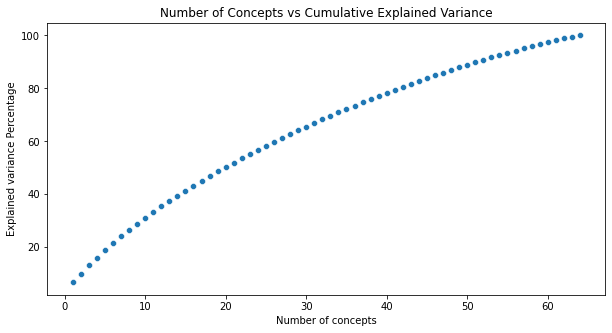

In [ ]:
# Apply PCA on training data and get the explained variance 

max_con = min(TfIDF_train.shape[0], TfIDF_train.shape[1])
n = PCA(n_components = max_con)
n.fit(TfIDF_train.toarray())
v = n.explained_variance_
var = n.explained_variance_ratio_
cum_var = var.cumsum()*100
x_data = [i for i in range(1,max_con+1)]

# Plotting explained variance with number of concepts 

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x = x_data, y = cum_var)
ax.set_title("Number of Concepts vs Cumulative Explained Variance")
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance Percentage')

In [ ]:
# To get the exact index where the variance is above 80% 

index = [j for j,v in enumerate(cum_var) if v > 80]
print(index[0])

41


### 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [ ]:
# Explained variance

ev = cum_var[2]
print('The first three concepts explain',ev,'% of the variance.')

The first three concepts explain 13.218736454861139 % of the variance.


In [ ]:
# Get 10 most important words for each component

words = TfIDFTransformer.get_feature_names_out()

In [ ]:
# Words for concept 1

imp = np.argpartition(n.components_[0,:], -10)[-10:]
print(words[imp])

['story' 'hawthorne' 'classic' 'books' 'read' 'book' 'writing' 'written'
 'reading' 'plot']


In [ ]:
# Words for concept 2 

imp = np.argpartition(n.components_[1,:], -10)[-10:]
print(words[imp])

['buy' 'years' 'wear' 'does' 'great' 'worth' 'love' 'book' 'recommend'
 'product']


In [ ]:
# Words for concept 3 

imp = np.argpartition(n.components_[2,:], -10)[-10:]
print(words[imp])

['bad' 'great' 'good' 'want' 'love' 'best' 'movie' 'really' 'better'
 'little']


###  1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


<AxesSubplot:>

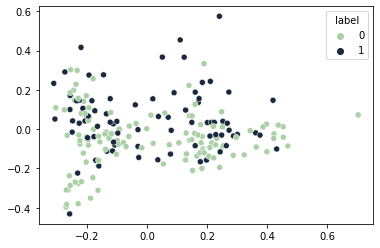

In [ ]:
# Apply PCA to the test dataset

a = n.transform(TfIDF_test.toarray())

# Plot the two different set of points with different markers and labels 

sns.scatterplot(x = a[:,0], y = a[:,1], hue = y_test, palette="ch:r=-.5,l=.75")

###  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.



UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', n_epochs=1000, n_neighbors=2, random_state=0, verbose=True)
Mon Dec  5 19:26:58 2022 Construct fuzzy simplicial set
Mon Dec  5 19:26:58 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:00 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:03 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:05 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.25, n_epochs=1000, n_neighbors=2, random_state=0, verbose=True)
Mon Dec  5 19:27:05 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:05 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:05 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:05 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:08 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.5, n_epochs=1000, n_neighbors=2, random_state=0, verbose=True)
Mon Dec  5 19:27:08 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:08 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:08 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:08 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:10 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', n_epochs=1000, n_neighbors=10, random_state=0, verbose=True)
Mon Dec  5 19:27:10 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:10 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:10 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:10 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:14 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.25, n_epochs=1000, n_neighbors=10, random_state=0, verbose=True)
Mon Dec  5 19:27:14 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:14 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:14 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:14 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:17 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.5, n_epochs=1000, n_neighbors=10, random_state=0, verbose=True)
Mon Dec  5 19:27:17 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:17 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:17 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:17 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:20 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', n_epochs=1000, n_neighbors=25, random_state=0, verbose=True)
Mon Dec  5 19:27:20 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:20 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:20 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:20 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:25 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.25, n_epochs=1000, n_neighbors=25, random_state=0, verbose=True)
Mon Dec  5 19:27:26 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:26 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:26 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:26 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:31 2022 Finished embedding
UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.5, n_epochs=1000, n_neighbors=25, random_state=0, verbose=True)
Mon Dec  5 19:27:31 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:31 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:31 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:31 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:37 2022 Finished embedding


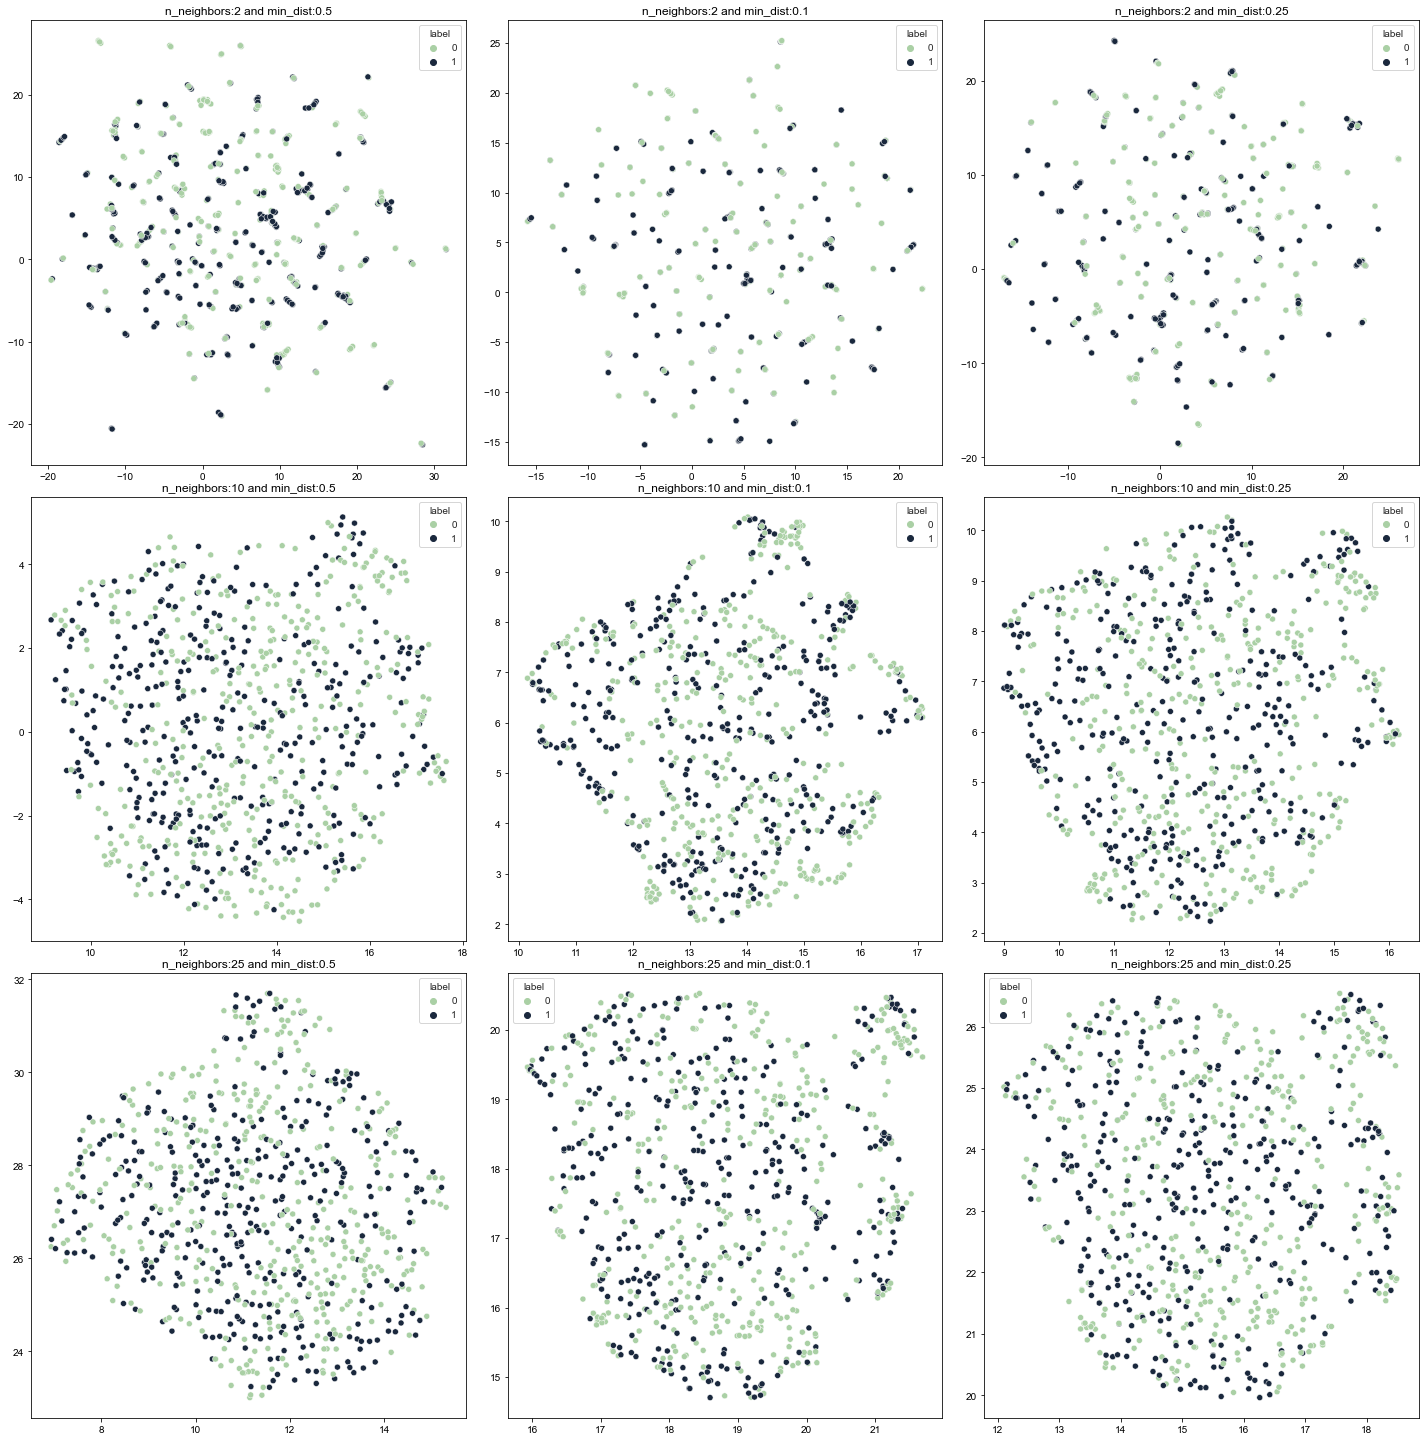

In [ ]:
# Set parameters
fig, axs = plt.subplots(3, 3, figsize=(20,20))
n_neighbors=[2, 10, 25]
min_dist=[0.1, 0.25, 0.5]
fig.tight_layout()
sns.set_style('white')

x = 0

# Create UMAP and plots 
for x, y_ in enumerate(itertools.product(n_neighbors, min_dist)):
    reducer = umap.UMAP(n_neighbors=y_[0],
                        n_components=2,metric='cosine',n_epochs=1000,
                        min_dist=y_[1],spread=1.0,low_memory=False,
                        n_jobs=-1,random_state=seed,verbose=True)
    UMAP_embedding = reducer.fit_transform(TfIDF_train)
    sns.scatterplot(ax = axs[int(x/3),(x+1)%3], x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=y_train, palette="ch:r=-.5,l=.75")
    axs[int(x/3),(x+1)%3].set_title(f"n_neighbors:{y_[0]} and min_dist:{y_[1]}")

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_epochs=1000, n_neighbors=25, random_state=0, verbose=True)
Mon Dec  5 19:27:38 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:38 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:38 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:38 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:27:44 2022 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

<AxesSubplot:>

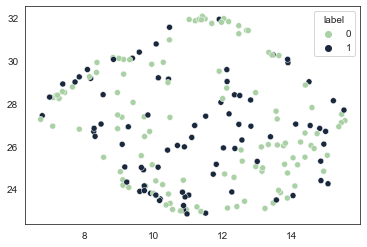

In [ ]:
# Choose the paramters that you think are best and apply to test set 

reducer = umap.UMAP(n_neighbors = 25,n_components = 2,
                    metric='cosine',n_epochs = 1000,
                    min_dist = 0.5,spread = 1.0,
                    low_memory=True,n_jobs=-1,
                    random_state=seed,verbose=True)

UMAP_train = reducer.fit_transform(TfIDF_train)
UMAP_test = reducer.transform(TfIDF_test)

# Create plot
sns.scatterplot(x = UMAP_test[:, 0], y = UMAP_test[:, 1], hue = y_test, palette = "ch:r=-.5,l=.75")

## Task 2: Benchmarking predictive capabilities of the compressed data 

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### 2.1 
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

AUC is: 0.6393816785973649


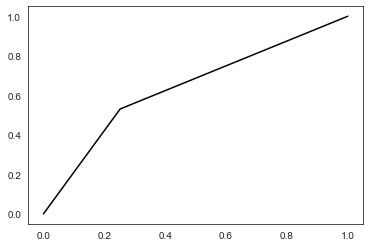

In [ ]:
# Train and test using model LogisticRegressionCV 

# Define the model
model = LogisticRegressionCV(random_state=seed)

# Fit on the training dataset
model.fit(TfIDF_train, y_train)

# Apply to the test dataset
y_pred = model.predict(TfIDF_test)

# Plot ROC curve and compute AUC score
# Calculate the ROC curve points and plot
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
ax = sns.lineplot(x = fpr, y = tpr, color = "black")

# Calculate the AUC and print it
auc = roc_auc_score(y_test, y_pred)
print("AUC is:", auc)

### 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

AUC is: 0.6603900819587094


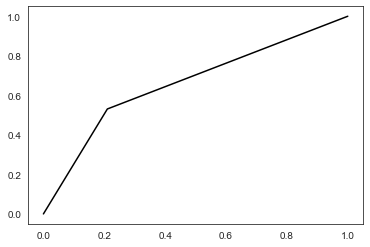

In [ ]:
# Apply SVD first
svd = TruncatedSVD(n_components = 10,n_iter = 10,random_state=seed)
svd_train = svd.fit_transform(TfIDF_train)
svd_test = svd.transform(TfIDF_test)

# Train and test using model LogisticRegressionCV 

# Define the model
model2 = LogisticRegressionCV(random_state=seed)

# Fit on the training dataset
model2.fit(svd_train, y_train)

# Apply to the test dataset
y_pred = model2.predict(svd_test)

# Plot ROC curve and compute AUC score 
# Calculate the ROC curve points and plot
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
ax = sns.lineplot(x=fpr, y=tpr, color="black")

# Calculate the AUC and print it
auc = roc_auc_score(y_test, y_pred)
print('AUC is:',auc)

### 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.25, n_components=10, n_epochs=1000, n_neighbors=25, random_state=0, verbose=True)
Mon Dec  5 19:27:53 2022 Construct fuzzy simplicial set
Mon Dec  5 19:27:53 2022 Finding Nearest Neighbors
Mon Dec  5 19:27:53 2022 Finished Nearest Neighbor Search
Mon Dec  5 19:27:53 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Mon Dec  5 19:28:00 2022 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

AUC is: 0.6568627450980391


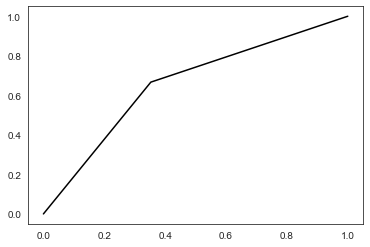

In [ ]:
# Apply UMAP first 

reducer = umap.UMAP(n_neighbors=25,n_components=10,metric='cosine',
                        n_epochs=1000,min_dist=0.25,
                        spread=1.0,low_memory=False,
                        n_jobs=-1,random_state=seed,verbose=True)
UMAP_train = reducer.fit_transform(TfIDF_train)
UMAP_test = reducer.transform(TfIDF_test)

# Train and test using model LogisticRegressionCV 

# Define the model
model3 = LogisticRegressionCV(random_state=seed, max_iter=1000)

# Fit on the training dataset
model3.fit(UMAP_train, y_train)

# Apply to the test dataset
y_pred = model3.predict(UMAP_test)


# Plot ROC curve and compute AUC score 
# Calculate the ROC curve points and plot
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
ax = sns.lineplot(x=fpr, y=tpr, color="black")

# Calculate the AUC and print it
auc = roc_auc_score(y_test, y_pred)
print("AUC is:",auc)